In [1]:
#Partially adopted from Tensorflow/docs/basic_text_classification
#https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/basic_text_classification.ipynb

#As well as https://developers.google.com/machine-learning/guides/text-classification/

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

import numpy as np

print(tf.__version__)

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
stopWords = stopwords.words('english')
from nltk import word_tokenize
stemmer = nltk.stem.SnowballStemmer('english')

Using TensorFlow backend.


1.11.0
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#MAPPING SENTENCES TO LIBRARY
import json

#declare testLabels as an empty list
testLabels = []

#Keeping track of used sentences
used = []

#Keeping track of used sentences separately
security = []
nosecurity = []

#this is the smallest number of unique non-functional requirements of a single class
LIMIT = 270

with open("Consolidated_data.txt","r") as f:
    
    #Go line by line in original data file
    for line in f:
        #find where class begins
        front = line.find("\"class\":\"")
        #find where class ends (where sentence begins)
        end = line.find("\",\"sentence\":\"")
        #substring line based on front and end above
        reqClass = (line[(front+9):end]).lower()

        #sentence
        temp = line.find("\"sentence\":\"")
        #Cut out the sentence part
        sentence = (line[(temp+12):-4]).lower()
        #Remove all symbols, numbers, and spaces. Split into list of words
        sentence = sentence.translate(None, '.,-\":;~!@#$%^&?[]{}<>`1234567890\\*()').strip().split(" ")
        #Unicode each word because stemmer likes it that way
        sentence = [unicode(i, 'utf-8') for i in sentence]
        #Stem each word separately
        sentence = [stemmer.stem(i) for i in sentence]
        #Check word by word, if the word is not in stop words and not a single letter, join
        sentence = ' '.join(word for word in sentence if word not in stopWords and len(word) > 1)
        
        if sentence in used:
            continue
        else:
            if "security" in reqClass and (len(security) < LIMIT):
                used.append(sentence)
                security.append(sentence)
                testLabels.append(1)
            elif "security" not in reqClass and (len(nosecurity) < LIMIT):
                used.append(sentence)
                nosecurity.append(sentence)
                testLabels.append(0)

In [4]:
#Must all be balanced for valid results.
#Commented out the total number of sentences in the document.
print len(security) #270
print len(nosecurity)
print len(used) #540

270
270
540


In [5]:
import csv
import requests

S = requests.Session()
URL = "https://en.wikipedia.org/w/api.php"

def parseList(*titleList):
    
    train = []
    
    for title in titleList:
        PARAMS = {
        'action': "parse",
        'page': title,
        'prop': 'wikitext',
        'format': "json"
        }
        
        entries = []
        pageContent = []
        
        res = S.get(url=URL, params=PARAMS)
        data = res.json()
        wikitext = data['parse']['wikitext']['*']
        lines = wikitext.split('|-')
        b = ",-\":;~!@#$%^&?[]{}<>`1234567890\\*()\'/|="
        for char in b:
            lines[0] = lines[0].replace(char, "")

        while lines[0].find("\n") is not (None or -1):
            current = lines[0].find("\n")
            entries.append(lines[0][:current+1])
            lines[0] = lines[0][current+1:]

        for line in entries:
            index = entries.index(line)

            #removing words that do not carry any meaning (longer than 16 chars)
            for key in line.split(" "):
                if len(key) > 16:
                    line = line.replace(key, "")

            #if line is not empty and wordcount > 20, line will be used for training
            if line != '\n' and (len(line.split(" ")) > 20):
                pageContent.append(line.strip())

        for paragraph in pageContent:
            for sentence in paragraph.split("."):
                sentence = sentence.strip().split(" ")
                if len(sentence) < 10:
                    continue
                #Stem each word separately
                sentence = [stemmer.stem(i) for i in sentence]
                #Check word by word, if the word is not in stop words and not a single letter, join
                sentence = ' '.join(word for word in sentence if word not in stopWords and len(word) > 1)
                train.append(sentence)
        del entries[:]
        del pageContent[:]
        print title, " parsed successfully"
    return train

In [6]:
def makeLabels(trainData, labelNumber):
    #generating labels list that matches pageContent list in length
    labels = []
    for x in range(0, len(trainData)):
        labels.append(labelNumber)
    print("Labels made successfully")
    return labels

In [7]:
#Two lists with names of all Wikipedia pages to be parsed and used for training
securityList = [
    "Information security",
    "Mobile security",
    "Computer security",
#     "Computer network",
#     "Network science",
#     "Secure by default",
    "Antivirus software",
    "Firewall (computing)",
    "Application security",
#     "Intrusion detection system"
]

notSecurityList = [
    "Medical diagnosis",
    "Hospital",
    "Medicine",
    "Medication",
    "Database administrator",
    "Database design",
    "Database model",
    "Relational model",
    "Network administrator",
    "ISO/IEC 9126",
    "Email",
    "Privacy",
    "Look and feel",
    "Access control",
    "Audit",
    "Service-level agreement",
    "Availability",
    "Channel capacity",
    "End-user license agreement",
    "Robustness (computer science)",
    "Software maintenance",
    "Operability",
    "Quality (business)",
    "Usability"
]

In [8]:
#Parse two wikipedia pages
security = parseList(*securityList)
notSecurity = parseList(*notSecurityList)
print "\nSecurity length: ", len(security)
print "Not Security length: ", len(notSecurity)

#Make entries be same length, pick minimum of two lengths
deleteAfter = min(len(security), len(notSecurity))

#If min length is less than 100 sentences, test is invalid
if deleteAfter < 100:
    print("!!!TEST IS INVALID!!!")
else:
    del security[deleteAfter:]
    del notSecurity[deleteAfter:]

if(len(security) != len(notSecurity) and (len(security) != len(set(security)) or len(notSecurity) != len(set(notSecurity)))):
    print("!!!TEST IS INVALID!!!")
else:
    #Generate labels
    trainLabels = makeLabels(security, 1)
    trainLabels += makeLabels(notSecurity, 0)

    #Collapse into single list
    trainData = security + notSecurity

    #Shuffle two lists, save the order
    trainData, trainLabels = shuffle(trainData, trainLabels)
    used, testLabels = shuffle(used, testLabels)

    #Get validation data
    validationToTrainRatio = 0.2
    validationSize = int(validationToTrainRatio * len(trainData))
    validationData = trainData[:validationSize]
    validationLabels = trainLabels[:validationSize]
    trainData = trainData[validationSize:]
    trainLabels = trainLabels[validationSize:]

    
    #Sanity check
    print "\nTest set length: ", len(used)
    print "Test labels set length: ", len(testLabels)
    print "\nValidation set length: ", len(validationData)
    print "Validation labels set length: ", len(validationLabels)
    print "\nTrain set length: ", len(trainData)
    print "Train labels set length: ", len(trainLabels)

Information security  parsed successfully
Mobile security  parsed successfully
Computer security  parsed successfully
Antivirus software  parsed successfully
Firewall (computing)  parsed successfully
Application security  parsed successfully
Medical diagnosis  parsed successfully
Hospital  parsed successfully
Medicine  parsed successfully
Medication  parsed successfully
Database administrator  parsed successfully
Database design  parsed successfully
Database model  parsed successfully
Relational model  parsed successfully
Network administrator  parsed successfully
ISO/IEC 9126  parsed successfully
Email  parsed successfully
Privacy  parsed successfully
Look and feel  parsed successfully
Access control  parsed successfully
Audit  parsed successfully
Service-level agreement  parsed successfully
Availability  parsed successfully
Channel capacity  parsed successfully
End-user license agreement  parsed successfully
Robustness (computer science)  parsed successfully
Software maintenance  par

In [9]:
def ngram_vectorize(train_texts, train_labels, val_texts, test_texts):
    
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': (1,3),  # Use 1-grams + 2-grams + 3-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
            'min_df': 2, #Words that appear less than this value do not contribute
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)
    
    # Vectorize test texts.
    x_test = vectorizer.transform(test_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(4000, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    x_test = selector.transform(x_test).astype('float32')
    return x_train, x_val, x_test

In [10]:
trainData, valData, testData = ngram_vectorize(trainData, trainLabels, validationData, used)

/usr/local/lib/python2.7/dist-packages/sklearn/feature_extraction/text.py:1547: UserWarning: Only (<type 'numpy.float64'>, <type 'numpy.float32'>, <type 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


In [11]:
#Constructing the model method
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    model = keras.Sequential()
    model.add(keras.layers.Dropout(rate=dropout_rate, input_shape=input_shape))
    for _ in range(layers-1):
        model.add(keras.layers.Dense(units=units, activation=tf.nn.relu))
        model.add(keras.layers.Dropout(rate=dropout_rate))

    model.add(keras.layers.Dense(units=num_classes, activation=tf.nn.sigmoid))
    return model

In [12]:
#For parameters refer to the upper cell
model = mlp_model(2, 32, 0.3, trainData.shape[1:], 1)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 4000)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                128032    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 128,065
Trainable params: 128,065
Non-trainable params: 0
_________________________________________________________________


In [13]:
#Learning rate could be further decreased for additional accuracy
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
#callbacks will prevent model from running if val_loss starts to increase
callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

history = model.fit(trainData,
                    trainLabels,
                    epochs=100,
                    callbacks = callbacks,
                    batch_size=256,
                    validation_data=(valData, validationLabels),
                    verbose=2)

Train on 2554 samples, validate on 638 samples
Epoch 1/100
 - 1s - loss: 0.6888 - acc: 0.5971 - val_loss: 0.6823 - val_acc: 0.7900
Epoch 2/100
 - 0s - loss: 0.6716 - acc: 0.8410 - val_loss: 0.6646 - val_acc: 0.8589
Epoch 3/100
 - 0s - loss: 0.6461 - acc: 0.9037 - val_loss: 0.6406 - val_acc: 0.8824
Epoch 4/100
 - 0s - loss: 0.6152 - acc: 0.9174 - val_loss: 0.6139 - val_acc: 0.8903
Epoch 5/100
 - 0s - loss: 0.5811 - acc: 0.9315 - val_loss: 0.5862 - val_acc: 0.8966
Epoch 6/100
 - 0s - loss: 0.5454 - acc: 0.9389 - val_loss: 0.5581 - val_acc: 0.8981
Epoch 7/100
 - 0s - loss: 0.5118 - acc: 0.9424 - val_loss: 0.5300 - val_acc: 0.8981
Epoch 8/100
 - 0s - loss: 0.4756 - acc: 0.9499 - val_loss: 0.5025 - val_acc: 0.8981
Epoch 9/100
 - 0s - loss: 0.4458 - acc: 0.9507 - val_loss: 0.4761 - val_acc: 0.9013
Epoch 10/100
 - 0s - loss: 0.4142 - acc: 0.9428 - val_loss: 0.4511 - val_acc: 0.8981
Epoch 11/100
 - 0s - loss: 0.3841 - acc: 0.9581 - val_loss: 0.4278 - val_acc: 0.9013
Epoch 12/100
 - 0s - loss: 

In [15]:
#Evalueating model on the testset
#[loss, accuracy]
print(model.evaluate(testData, testLabels))

540/540 [==============================] - 0s 84us/step
[0.5739327832504555, 0.7814814801569339]


In [16]:
#The rest of the notebook helps vidualize losses and accuracies by ploting two separate grophs
history_dict = history.history
history_dict.keys()

['acc', 'loss', 'val_acc', 'val_loss']

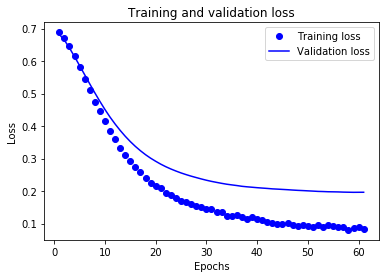

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

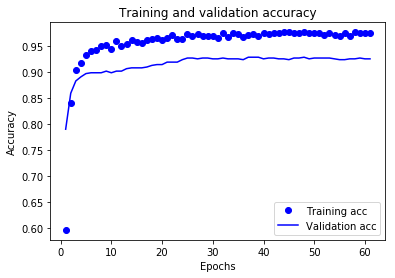

In [18]:
plt.clf() #clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()